In [1]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

2024-09-04 10:42:08.565512: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs found: 0


2024-09-04 10:42:11.241710: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-04 10:42:11.241766: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 6223ee3d0108
2024-09-04 10:42:11.241773: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 6223ee3d0108
2024-09-04 10:42:11.241890: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.183.1
2024-09-04 10:42:11.241931: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.183.1
2024-09-04 10:42:11.241942: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.183.1


In [2]:
from orbit_generation.visualize import visualize_static_orbits
from orbit_generation.dataset import get_first_period_dataset
from orbit_generation.experiment import get_experiment_parameters
from orbit_generation.propagation import jacobi_constant
from orbit_generation.constants import EM_MU

In [3]:
import numpy as np
import tsgm
import os
import pandas as pd

2024-09-04 10:42:13.052403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load

Paths

In [4]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = r'../experiments'
experiment_folder = r'../experiments/experiment_4'
experiment_id = int(experiment_folder[-1])

In [5]:
images_folder = os.path.join(experiment_folder, 'images')
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
initial_conditions_file = os.path.join(experiment_folder, f'exp{experiment_id}_corrected_initial_conditions.npy')
generated_data_file = os.path.join(experiment_folder, f'exp{experiment_id}_propagated_corrected_ICs.npy')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')

Dataset

In [6]:
params=get_experiment_parameters(experiments_folder=experiments_folder, experiment_id=experiment_id)
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 100)

In [7]:
transposed_orbits = np.transpose(data, (0, 2, 1))

if transposed_orbits.shape[2] == 7:
    full_data = transposed_orbits[:,:,1:]
else:
    full_data = transposed_orbits

full_data.shape

(45211, 100, 6)

In [8]:
results = np.array([jacobi_constant(full_data[i][0], EM_MU)[0] for i in range(full_data.shape[0])])
orbit_df['calculated_jacobi'] = results

In [9]:
orbit_df.head()

,id_class,x_0,y_0,x_0,vx_0,vy_0,vz_0,jacobi,period,stability,propagated_periods,calculated_jacobi
0,1.0,0.941000,1.900442e-23,0.509474,2.968938e-13,-0.124968,-3.122717e-12,2.745412,11.555291,211.184678,3.0,2.757415
1,1.0,0.941538,-8.592698e-24,0.508602,2.902340e-13,-0.125672,-3.252212e-12,2.746226,11.551622,210.329145,3.0,2.758229
2,1.0,0.942076,6.956604e-24,0.507729,2.685527e-13,-0.126375,-2.862050e-12,2.747039,11.547936,209.473685,3.0,2.759042
3,1.0,0.942613,1.763946e-24,0.506856,3.153637e-13,-0.127078,-3.791054e-12,2.747850,11.544233,208.618315,3.0,2.759853
4,1.0,0.943150,9.441804e-24,0.505982,2.663322e-13,-0.127781,-2.982720e-12,2.748660,11.540511,207.763051,3.0,2.760663


Refined Orbits

In [10]:
initial_conditions = np.load(initial_conditions_file)
columns= ['id','old_period', 'new_period', 'iterations_convergence','error','pos_x0','pos_y0','pos_z0','vel_x0','vel_y0','vel_z0']
synthetic_orbit_df = pd.DataFrame(initial_conditions, columns=columns)
generated_data = np.load(generated_data_file)
generated_data.shape

(46, 100, 7)

In [11]:
if generated_data.shape[2] == 7:
    display_generation = generated_data[:,:,1:]
else:
    display_generation = generated_data

display_generation.shape

(46, 100, 6)

In [25]:
new_jacobis = np.array([jacobi_constant(display_generation[i][0], EM_MU)[0] for i in range(display_generation.shape[0])])
synthetic_orbit_df['calculated_jacobi'] = new_jacobis
synthetic_orbit_df.rename(columns={'new_period': 'period'}, inplace=True)

In [26]:
synthetic_orbit_df.head()

,id,old_period,period,iterations_convergence,error,pos_x0,pos_y0,pos_z0,vel_x0,vel_y0,vel_z0,calculated_jacobi
0,2.0,6.348769,6.311056,8.0,8.170653e-10,0.724026,0.435854,5.338609e-01,0.814150,-1.622988,2.131926e-01,-0.624084
1,4.0,18.210407,17.822647,11.0,4.091293e-12,0.758843,0.097509,-1.774103e-15,0.095262,0.674450,2.800786e-15,2.773315
2,5.0,24.626577,25.183559,8.0,4.100514e-11,3.705281,0.072228,4.297126e-11,0.065610,-3.327296,1.357003e-11,3.211436
3,10.0,10.952934,10.906589,7.0,6.873462e-12,0.692369,-0.067674,3.116010e-14,0.005554,0.547222,2.725087e-14,3.068114
4,13.0,5.315282,3.619671,11.0,4.742243e-12,0.797006,0.143057,-9.735460e-02,-0.084086,0.407244,-2.277034e-01,2.924941


# Compare

In [32]:
import numpy as np
from scipy.spatial import cKDTree

def calculate_closest_distances(orbit_df, synthetic_orbit_df, features):
    """
    Calculate the distance from each point in synthetic_orbit_df to the closest point in orbit_df
    based on specified features.
    
    Parameters:
    - orbit_df: DataFrame containing the training data.
    - synthetic_orbit_df: DataFrame containing the synthetic data.
    - features: List of features (columns) to use for calculating the distances.
    
    Returns:
    - distances: A NumPy array of the minimum distances from each synthetic point to the nearest orbit point.
    """
    # Extract the relevant features from both DataFrames
    orbit_points = orbit_df[features].values
    synthetic_points = synthetic_orbit_df[features].values

    # Create a KDTree for efficient nearest-neighbor search in orbit_df
    tree = cKDTree(orbit_points)

    # Query the KDTree with the synthetic points to find the distance to the nearest orbit point
    distances, _ = tree.query(synthetic_points, k=1)

    return distances

In [33]:
# Define the features to be used for distance calculation
features = ['period', 'calculated_jacobi']

# Calculate the distances
distances = calculate_closest_distances(orbit_df, synthetic_orbit_df, features)

In [34]:
distances

array([4.77263454e-05, 1.37359368e-03, 3.59152781e-04, 3.33361160e-03,
       1.70453828e-03, 1.38083654e-03, 3.95233836e-03, 3.12887875e-06,
       5.04477244e-04, 1.73351928e+00, 3.61373514e-02, 9.85065398e-04,
       2.29724015e-02, 1.81921350e-03, 1.49328772e-04, 6.54857310e-04,
       1.58651706e-03, 1.51026631e-05, 4.52544319e-03, 6.86182450e-04,
       7.85795265e-05, 1.35244379e-04, 5.53641402e-04, 2.55906162e-04,
       1.89098411e-04, 2.62390281e-02, 3.76061821e-01, 1.66398531e-04,
       3.74177208e-04, 4.84680658e-04, 3.86916151e-04, 3.45741499e-04,
       9.26362838e-04, 1.20335908e-03, 3.02354395e-04, 4.20367265e-04,
       2.73992181e-04, 1.95613650e-02, 1.24380790e-04, 9.33676327e-04,
       2.71103017e-04, 4.30811245e-05, 1.17344658e-04, 4.81140357e-04,
       2.00620605e-03, 1.54497340e-04])

In [29]:
import matplotlib.pyplot as plt

def plot_comparison(orbit_df, synthetic_orbit_df):
    """
    Function to create a scatter plot comparing 'period' and 'calculated_jacobi'
    between two DataFrames and plot the index of points in synthetic_orbit_df.
    
    Parameters:
    - orbit_df: DataFrame containing 'period' and 'calculated_jacobi' columns
    - synthetic_orbit_df: DataFrame containing 'period' and 'calculated_jacobi' columns
    """
    plt.figure(figsize=(10, 6))

    # Plot for orbit_df
    plt.scatter(orbit_df['period'], orbit_df['calculated_jacobi'], color='blue', label='orbit_df', marker='o')

    # Plot for synthetic_orbit_df
    plt.scatter(synthetic_orbit_df['period'], synthetic_orbit_df['calculated_jacobi'], color='red', label='synthetic_orbit_df', marker='x')

    # Annotate the points in synthetic_orbit_df with their indices
    for i in synthetic_orbit_df.index:
        plt.text(synthetic_orbit_df['period'].loc[i], 
                 synthetic_orbit_df['calculated_jacobi'].loc[i], 
                 str(int(i)), 
                 fontsize=9, color='black', ha='right')

    # Add labels and title
    plt.xlabel('Period')
    plt.ylabel('Calculated Jacobi')
    plt.title('Comparison of Features Between Two DataFrames')
    plt.legend()  # Add legend to distinguish between the groups

    # Display the plot
    plt.grid(True)
    plt.show()

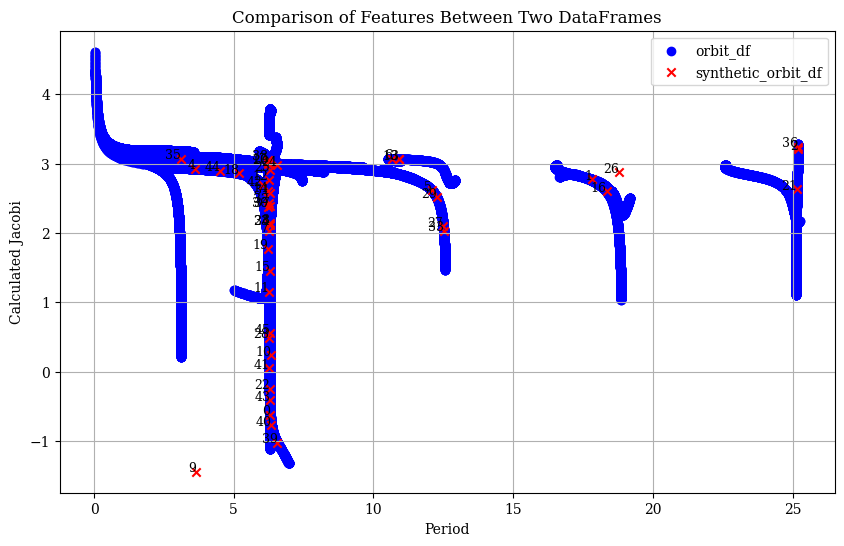

In [30]:
plot_comparison(orbit_df, synthetic_orbit_df)

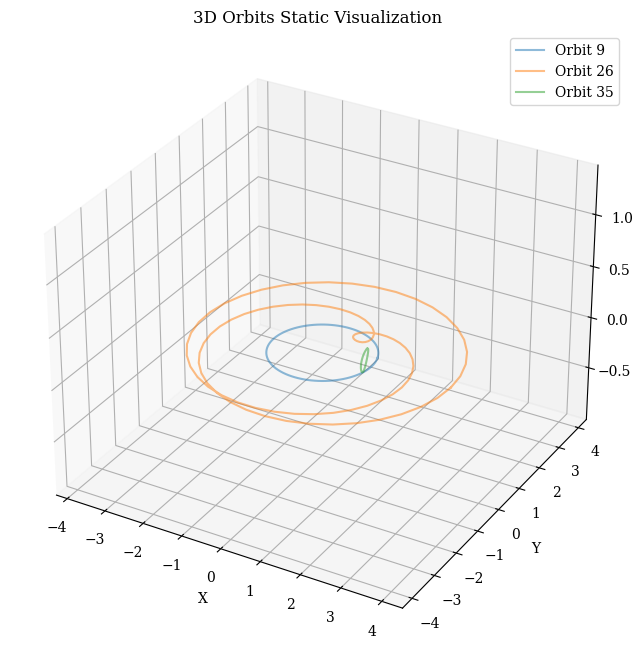

In [20]:
visualize_static_orbits(np.transpose(display_generation, (0, 2, 1)), orbit_indices=[9,26,35])